# Imports

In [1]:
import os
from pathlib import Path
import itertools
import shutil
import time
import h5py
from itertools import cycle, islice
from datetime import datetime

import torch
from torchvision import transforms
from torchvision.datasets.folder import default_loader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact

import IPython
from IPython.display import Markdown, display, YouTubeVideo

from tqdm.notebook import tqdm

In [2]:
import sys
sys.path.append('/Users/staveshemesh/Projects/shstav2/vokenization')
sys.path.append('/Users/staveshemesh/Projects/shstav2/vokenization/vokenization')
sys.path.append('/Users/staveshemesh/Projects/shstav2/FECNet')
sys.path.append('/Users/staveshemesh/Projects/shstav2/token_voken')

In [3]:
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_colwidth = 300

# Helpers

## Paths Resolvers

In [4]:
from src.path_resolvers import *

## Display Utils

In [5]:
def printmd(string):
    display(Markdown(string))

CAPTION_STYLE = {
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '16px')
    ]
}

def df_with_caption(df, title):
    return df.style.set_caption(title).set_table_styles([CAPTION_STYLE])
    
def style_value_counts(mask, title):
    df_value_counts = (pd.Series(mask.reshape(-1))).value_counts().to_frame().head()
    df_style = df_with_caption(df_value_counts, title)
    display(df_style)

## Constants

In [6]:
FRAME_RATE = 15
SAMPLE_INTERVAL = '214625'
SPEAKER_NAME = 'oliver'
TAB = '&nbsp;&nbsp;&nbsp;&nbsp;'

# Read Data

## Constants for Paths

In [7]:
DATA_ROOT = '/Users/staveshemesh/Projects/shstav2/token_voken/data/'
INTERVALS_FILE = '20210506_135358_df_intervals_batch1_431.csv'
INTERVALS_PATH = os.path.join(DATA_ROOT, INTERVALS_FILE)

PATS_DATA_ROOT = '/Users/staveshemesh/Projects/PATS_DATA/'
PATS_SPEAKER_VIZ_DIR = os.path.join(PATS_DATA_ROOT, f'Youtube/{SPEAKER_NAME}')
PATS_SPEAKER_DATA_DIR = os.path.join(PATS_DATA_ROOT, f'Processed/{SPEAKER_NAME}/data')
PATS_SPEAKER_PATS_INTERVAL_DIR = os.path.join(PATS_SPEAKER_DATA_DIR, 'processed', SPEAKER_NAME)

# Output files:
#   1. DataFrames
#   2. Model Input files
# Output Dir
TIMESTR = time.strftime("%Y%m%d_%H%M%S")
OUTPUT_ITERATION_DIR = os.path.join(DATA_ROOT, TIMESTR)
OUTPUT_DATAFRAMES_ITERATION_DIR = os.path.join(OUTPUT_ITERATION_DIR, 'dataframes')
#  Model Input files
OUTPUT_TOKENS_PATH = os.path.join(OUTPUT_ITERATION_DIR, 'sample_token_ids_{count}.hdf5')
OUTPUT_VOKENS_PATH = os.path.join(OUTPUT_ITERATION_DIR, 'sample_voken_ids_{count}.hdf5')
OUTPUT_VOKEN_IDS_PATH = os.path.join(OUTPUT_ITERATION_DIR, '{dataset}_{count}.ids')
OUTPUT_VOKEN_KEYS_PATH = os.path.join(OUTPUT_ITERATION_DIR, 'keys')

## DataFrames

### df_intervals

In [8]:
dtypes = {'interval_id': object}
df_intervals = pd.read_csv(INTERVALS_PATH, dtype=dtypes, parse_dates=['start_time'])
interval_ids = df_intervals['interval_id'].tolist()
df_intervals.shape

(431, 33)

In [9]:
df_intervals['start_time'] = pd.to_timedelta(df_intervals['start_time_string'])
df_intervals['end_time'] = pd.to_timedelta(df_intervals['end_time_string'])

In [10]:
df_intervals.columns

Index(['speaker', 'video_id', 'interval_id', 'valid', 'duration',
       'start_time_string', 'end_time_string', 'video_link', 'video_fn',
       'start_time', 'end_time', 'org_start_time', 'org_end_time',
       'max_frames_token', 'valid_duration', 'valid_single_token_per_frame',
       'video_downloded', 'valid_hd5', 'valid_max_token_duration',
       'valid_frames_count', 'video_downloaded', 'interval_video_path',
       'interval_video_downloaded', 'interval_frames_dir', 'full_video_path',
       'frames_dir_exists', 'frames_dir_content_size', 'frames_count',
       'supposed_frames_count', 'missing_frames_count', 'has_completed_frames',
       'pats_path', 'word_count'],
      dtype='object')

In [11]:
all_interval_texts = []

for interval_id in interval_ids:
    df_interval_words = read_text(interval_id)
    df_interval_words['interval_id'] = interval_id
    all_interval_texts.append(df_interval_words)

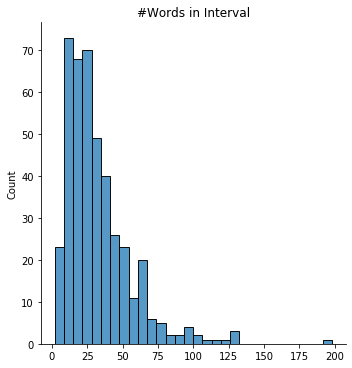

In [12]:
word_counts = np.array([df_interval_words.shape[0] for df_interval_words in all_interval_texts])
sns.displot(word_counts)
plt.title('#Words in Interval');

In [13]:
df_word_to_frame = pd.concat(all_interval_texts)
df_word_to_frame.rename(columns={'Word': 'word_original'}, inplace=True)

In [14]:
df_word_to_frame['frame_selected'] = df_word_to_frame[['start_frame', 'end_frame']].mean(axis=1).astype(int)

In [15]:
df_token_voken = df_word_to_frame.merge(df_intervals, on='interval_id')

In [16]:
df_token_voken.head(n=3)

,word_original,start_frame,end_frame,frames_count_x,interval_id,frame_selected,speaker,video_id,valid,duration,...,interval_frames_dir,full_video_path,frames_dir_exists,frames_dir_content_size,frames_count_y,supposed_frames_count,missing_frames_count,has_completed_frames,pats_path,word_count
0,and,0,5,5,100913,2,oliver,Tt-mpuR_QHQ,True,7.74,...,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,True,3840,118,116,2,True,/Users/staveshemesh/Projects/PATS_DATA/Processed/oliver/data/processed/oliver/100913.h5,17
1,small,5,8,3,100913,6,oliver,Tt-mpuR_QHQ,True,7.74,...,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,True,3840,118,116,2,True,/Users/staveshemesh/Projects/PATS_DATA/Processed/oliver/data/processed/oliver/100913.h5,17
2,businesses,8,15,7,100913,11,oliver,Tt-mpuR_QHQ,True,7.74,...,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,True,3840,118,116,2,True,/Users/staveshemesh/Projects/PATS_DATA/Processed/oliver/data/processed/oliver/100913.h5,17


In [17]:
df_token_voken['frame_path'] = \
    df_token_voken['frame_selected'].astype(str) + '_' + \
    df_token_voken['interval_id'] + '_' + \
    df_token_voken['video_id']
df_token_voken['frame_count'] = df_token_voken['end_frame'] - df_token_voken['start_frame']

# /Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00000.png
# Don't use resolvers, to vectorize this calculation
df_token_voken['frame_full_path'] = PATS_SPEAKER_VIZ_DIR + '/' + \
    df_token_voken['video_id'] + '/' + df_token_voken['interval_id'] + \
    '/vokens/face_annot_224/' + \
    df_token_voken['frame_selected'].astype(str).str.zfill(5) + '.png'

df_token_voken['frame_face_path'] = PATS_SPEAKER_VIZ_DIR + '/' + \
    df_token_voken['video_id'] + '/' + df_token_voken['interval_id'] + \
    '/vokens/face_annot_224/' + \
    df_token_voken['frame_selected'].astype(str).str.zfill(5) + '/' + 'detected_face_0.png'

# calculage word len, start and end
df_token_voken['word_len_plus_1'] = df_token_voken['word_original'].str.len() + 1
df_token_voken['word_end'] = df_token_voken.groupby('interval_id')['word_len_plus_1'].transform(pd.Series.cumsum)
df_token_voken['word_start'] = df_token_voken['word_end'] - df_token_voken['word_len_plus_1'] + 1
# fix spacing offsets
df_token_voken['word_start'] = df_token_voken['word_start'] - 1
df_token_voken['word_end'] = df_token_voken['word_end'] - 1
df_token_voken['word_time'] = round(df_token_voken['frame_selected'] / FRAME_RATE, 1)
df_token_voken['word_time_abs'] = df_token_voken['start_time'] + pd.to_timedelta(df_token_voken['word_time'], unit='s')


df_token_voken.rename(
    columns={'start_frame': 'frame_start', 'end_frame': 'frame_end', 'duration': 'interval_time'},
    inplace=True)

#reorder columns
TOKEN_VOKEN_COLS = [
    # token-voken
    'word_original', 'frame_selected',
    # token metadata
     'word_time', 'word_time_abs', 'word_len_plus_1', 'word_start', 'word_end',
    # voken metadata
    'frame_start', 'frame_end', 'frame_count', 'frame_path', 'frame_full_path', 'frame_face_path',
    # additional info
    'interval_id', 'video_id', 'video_link', 'full_video_path', 'interval_time'
]
df_token_voken = df_token_voken[TOKEN_VOKEN_COLS]
df_token_voken.sort_values(['interval_id', 'frame_selected'], inplace=True)

print(f'Number of word-frame pairs: {df_token_voken.shape[0]:,}')

Number of word-frame pairs: 14,026


In [18]:
df_token_voken.sample(n=3)

,word_original,frame_selected,word_time,word_time_abs,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_full_path,frame_face_path,interval_id,video_id,video_link,full_video_path,interval_time
9718,to,447,29.80,00:13:51.360000,3,409,411,447,448,1,447_104413_YEGpriv2TAc,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/YEGpriv2TAc/104413/vokens/face_annot_224/00447.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/YEGpriv2TAc/104413/vokens/face_annot_224/00447/detected_face_0.png,104413,YEGpriv2TAc,http://www.youtube.com/watch?v=YEGpriv2TAc,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/YEGpriv2TAc/YEGpriv2TAc.mp4,70.40
5120,of,241,16.10,00:08:21.750000,3,160,162,240,242,2,241_101592_Nn_Zln_4pA8,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Nn_Zln_4pA8/101592/vokens/face_annot_224/00241.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Nn_Zln_4pA8/101592/vokens/face_annot_224/00241/detected_face_0.png,101592,Nn_Zln_4pA8,http://www.youtube.com/watch?v=Nn_Zln_4pA8,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Nn_Zln_4pA8/Nn_Zln_4pA8.mp4,16.68
10860,January,135,9.00,00:08:58.230000,8,138,145,131,140,9,135_104532_YEGpriv2TAc,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/YEGpriv2TAc/104532/vokens/face_annot_224/00135.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/YEGpriv2TAc/104532/vokens/face_annot_224/00135/detected_face_0.png,104532,YEGpriv2TAc,http://www.youtube.com/watch?v=YEGpriv2TAc,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/YEGpriv2TAc/YEGpriv2TAc.mp4,20.00


### df_interval_texts

In [19]:
df_token_voken.head()

,word_original,frame_selected,word_time,word_time_abs,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_full_path,frame_face_path,interval_id,video_id,video_link,full_video_path,interval_time
0,and,2,0.10,00:10:47.540000,4,0,3,0,5,5,2_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00002.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00002/detected_face_0.png,100913,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74
1,small,6,0.40,00:10:47.840000,6,4,9,5,8,3,6_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00006.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00006/detected_face_0.png,100913,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74
2,businesses,11,0.70,00:10:48.140000,11,10,20,8,15,7,11_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00011.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00011/detected_face_0.png,100913,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74
3,by,17,1.10,00:10:48.540000,3,21,23,15,20,5,17_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00017.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00017/detected_face_0.png,100913,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74
4,exempting,33,2.20,00:10:49.640000,10,24,33,20,47,27,33_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00033.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00033/detected_face_0.png,100913,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74


In [20]:
df_interval_text = df_token_voken.groupby('interval_id')['word_original'].apply(' '.join).reset_index()

df_interval_text.rename(columns={'word_original': 'text'}, inplace=True)
df_interval_text.sort_values('interval_id', inplace=True)

print(f'Intervals: {df_interval_text.shape[0]}')
df_interval_text.head(n=2).style.set_properties(**{'text-align': 'left', 'font-size': '12pt'})

Intervals: 431


,interval_id,text
0,100913,and small businesses by exempting them from capital gains taxes which you have to admit he's pretty
1,100937,look up once even created a video to sell my reminders on moving featuring a businessman talkin and spectacularly condescending songs about how unexpectedly civilized life in Puerto


## Data Validity Check

### Original Word Bounds

In [21]:
df_token_voken.head(n=2)

,word_original,frame_selected,word_time,word_time_abs,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_full_path,frame_face_path,interval_id,video_id,video_link,full_video_path,interval_time
0,and,2,0.10,00:10:47.540000,4,0,3,0,5,5,2_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00002.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00002/detected_face_0.png,100913,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74
1,small,6,0.40,00:10:47.840000,6,4,9,5,8,3,6_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00006.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00006/detected_face_0.png,100913,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74


In [22]:
print(df_token_voken.head(n=10)['word_original'].tolist())

['and', 'small', 'businesses', 'by', 'exempting', 'them', 'from', 'capital', 'gains', 'taxes']


In [23]:
print(all_interval_texts[90][10:30]['Word'].tolist())

['tendency', 'to', 'go', 'south', 'first', "we've", 'all', 'seen', 'tragic', 'headlines', 'about', 'lottery', 'winners', 'like', 'a', 'lottery', 'winner', 'blows', 'through', '27']


In [24]:
test_items = {
    '101376': ['tendency', 'to', 'go', 'south', 'first', "we've", 'all', 'seen', 'tragic', 'headlines', 'about', 'lottery', 'winners', 'like', 'a', 'lottery', 'winner', 'blows', 'through', '27'],
#     '102545': ['problems', 'because', 'the', 'industry', 'boomed', 'that', 'I', 'found', 'it', 'in', 'kickbacks']
}

for test_interval_id, test_words in test_items.items():
    interval_text = df_interval_text[df_interval_text['interval_id'] == test_interval_id].iloc[0]['text']
    printmd('**interval full text:**')
    df_token_voken_interval = df_token_voken[df_token_voken['interval_id'] == test_interval_id]
    print(interval_text)
    for word in test_words:
        start, end = df_token_voken_interval[df_token_voken_interval['word_original'] == word].iloc[0][['word_start', 'word_end']]
        sliced_word = interval_text[start:end]
        printmd(f'{TAB} ✓ **{sliced_word.replace(" ","SPACE")}** text[start={start}:end={end}]:')
        assert word == sliced_word

**interval full text:**

but even when people to win big things have a tendency to go south first we've all seen tragic headlines about lottery winners like a lottery winner blows through 27 million lottery winner found dead in bed or brother hide Hitman over 16 Million jackpot win it seems winning the lottery can be like marrying Tom Cruise it seems amazing. good morning even dream about you how many Bonsai but if it actually does five years later the magic will be over you'll be estranged from your family and you would have seen things you can never unsee you never


&nbsp;&nbsp;&nbsp;&nbsp; ✓ **tendency** text[start=46:end=54]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **to** text[start=21:end=23]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **go** text[start=58:end=60]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **south** text[start=61:end=66]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **first** text[start=67:end=72]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **we've** text[start=73:end=78]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **all** text[start=79:end=82]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **seen** text[start=83:end=87]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **tragic** text[start=88:end=94]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **headlines** text[start=95:end=104]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **about** text[start=105:end=110]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **lottery** text[start=111:end=118]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **winners** text[start=119:end=126]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **like** text[start=127:end=131]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **a** text[start=44:end=45]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **lottery** text[start=111:end=118]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **winner** text[start=142:end=148]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **blows** text[start=149:end=154]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **through** text[start=155:end=162]:

&nbsp;&nbsp;&nbsp;&nbsp; ✓ **27** text[start=163:end=165]:

### Word's Selected Frame

In [25]:
test_words = ['lottery']
test_interval_id = '101376'

In [26]:
df_interval_text[df_interval_text['interval_id'] == test_interval_id].iloc[0]['text']

"but even when people to win big things have a tendency to go south first we've all seen tragic headlines about lottery winners like a lottery winner blows through 27 million lottery winner found dead in bed or brother hide Hitman over 16 Million jackpot win it seems winning the lottery can be like marrying Tom Cruise it seems amazing. good morning even dream about you how many Bonsai but if it actually does five years later the magic will be over you'll be estranged from your family and you would have seen things you can never unsee you never"

In [27]:
for test_word in test_words:
    mask = (df_token_voken['interval_id'] == test_interval_id) & (df_token_voken['word_original'] == test_word)
    n = 3
    selected_frame, word_time = df_token_voken[mask].iloc[0][['frame_selected', 'word_time_abs']]
    idx = df_token_voken[mask].index[0]
    printmd(f'**{test_word}** - frame {selected_frame} at {word_time}')
    display(df_token_voken.loc[idx-n:idx+n])

**lottery** - frame 116 at 0 days 00:05:38.300000

,word_original,frame_selected,word_time,word_time_abs,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_full_path,frame_face_path,interval_id,video_id,video_link,full_video_path,interval_time
3244,tragic,100,6.70,00:05:37.300000,7,88,94,95,105,10,100_101376_9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00100.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00100/detected_face_0.png,101376,9PK-netuhHA,https://www.youtube.com/watch?v=9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/9PK-netuhHA.mp4,37.97
3245,headlines,108,7.20,00:05:37.800000,10,95,104,105,111,6,108_101376_9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00108.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00108/detected_face_0.png,101376,9PK-netuhHA,https://www.youtube.com/watch?v=9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/9PK-netuhHA.mp4,37.97
3246,about,112,7.50,00:05:38.100000,6,105,110,111,113,2,112_101376_9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00112.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00112/detected_face_0.png,101376,9PK-netuhHA,https://www.youtube.com/watch?v=9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/9PK-netuhHA.mp4,37.97
3247,lottery,116,7.70,00:05:38.300000,8,111,118,113,119,6,116_101376_9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00116.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00116/detected_face_0.png,101376,9PK-netuhHA,https://www.youtube.com/watch?v=9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/9PK-netuhHA.mp4,37.97
3248,winners,120,8.00,00:05:38.600000,8,119,126,119,122,3,120_101376_9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00120.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00120/detected_face_0.png,101376,9PK-netuhHA,https://www.youtube.com/watch?v=9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/9PK-netuhHA.mp4,37.97
3249,like,125,8.30,00:05:38.900000,5,127,131,122,128,6,125_101376_9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00125.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00125/detected_face_0.png,101376,9PK-netuhHA,https://www.youtube.com/watch?v=9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/9PK-netuhHA.mp4,37.97
3250,a,128,8.50,00:05:39.100000,2,132,133,128,128,0,128_101376_9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00128.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/101376/vokens/face_annot_224/00128/detected_face_0.png,101376,9PK-netuhHA,https://www.youtube.com/watch?v=9PK-netuhHA,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/9PK-netuhHA/9PK-netuhHA.mp4,37.97


In [28]:
df_token_voken.loc[idx]['video_link']

'https://www.youtube.com/watch?v=9PK-netuhHA'

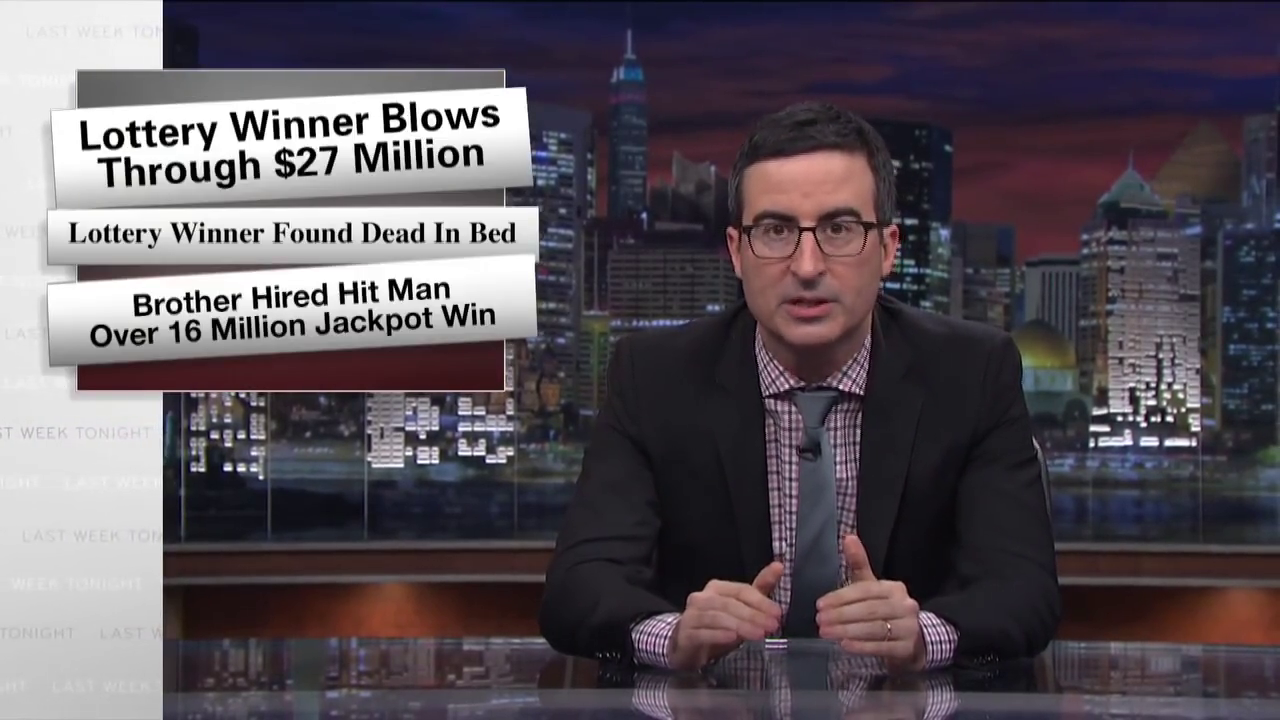

In [29]:
IPython.display.Image(df_token_voken.loc[idx]['frame_full_path'])

In [30]:
#IPython.display.YouTubeVideo(df_token_voken.loc[idx]['video_link'], embed=True, width=500, height=500)

In [31]:
@interact(frame_id=widgets.IntSlider(min=0, max=get_frame_count(test_interval_id), step=1, value=10))
def show_img(frame_id):
    interval_frames_dir = resolve_interval_frames_dir(df_intervals, test_interval_id)
    frame_path = os.path.join(interval_frames_dir, f'{frame_id:05d}.png')
    image = IPython.display.Image(filename=frame_path, width=500, height=500)
    display(image)

interactive(children=(IntSlider(value=10, description='frame_id', max=570), Output()), _dom_classes=('widget-i…

### Frame Value Count 

In [32]:
style_value_counts(df_token_voken['frame_path'].values, 'Words per Frame')

,0
135_101006_CesHr99ezWE,2
187_101444_r-ERajkMXw0,2
86_101392_umqvYhb3wf4,2
0_101792_gvZSpET11ZY,2
74_104416_7y1xJAVZxXg,2


# Prepare Training Data

## Bert Input Ids

### Encode Text

In [33]:
!rm -rf /Users/staveshemesh/.cache/huggingface/transformers/transformers

In [34]:
from transformers import AutoTokenizer

In [35]:
tokenizer_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)

In [36]:
df_token_voken.head()

,word_original,frame_selected,word_time,word_time_abs,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_full_path,frame_face_path,interval_id,video_id,video_link,full_video_path,interval_time
0,and,2,0.10,00:10:47.540000,4,0,3,0,5,5,2_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00002.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00002/detected_face_0.png,100913,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74
1,small,6,0.40,00:10:47.840000,6,4,9,5,8,3,6_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00006.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00006/detected_face_0.png,100913,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74
2,businesses,11,0.70,00:10:48.140000,11,10,20,8,15,7,11_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00011.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00011/detected_face_0.png,100913,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74
3,by,17,1.10,00:10:48.540000,3,21,23,15,20,5,17_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00017.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00017/detected_face_0.png,100913,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74
4,exempting,33,2.20,00:10:49.640000,10,24,33,20,47,27,33_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00033.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00033/detected_face_0.png,100913,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74


In [37]:
df_interval_text.head()

,interval_id,text
0,100913,and small businesses by exempting them from capital gains taxes which you have to admit he's pretty
1,100937,look up once even created a video to sell my reminders on moving featuring a businessman talkin and spectacularly condescending songs about how unexpectedly civilized life in Puerto
2,100945,scientologists do not believe in Psychiatry that means eme is literally cooled Psychiatry an industry of death going to the Museum of Scientology for your sake I took rotation is
3,100958,Corinthian about the we point out a few things such as the fact that those women like to sue the school a financial settlement was reached
4,100970,look up with the federal government does try to regulate the schools they are only allowed 90% of their funding to come from Federal loans however for-profit schools have found themselves a truly


In [49]:
COLS_DATASET = [
    # main elements
    'word_original', 'bert_token', 'token_id', 'frame_selected', 'interval_id',
    # bert token metadata
    'offset_start', 'offset_end',
    # original word metadata
    'word_time', 'word_len_plus_1', 'word_start', 'word_end',
    # word frames metadata
    'frame_start', 'frame_end', 'frame_count', 'frame_path', 'frame_full_path', 'frame_face_path',
    # additional info
    'video_id', 'interval_time'
]

In [50]:
# https://stackoverflow.com/questions/44367672/best-way-to-join-merge-by-range-in-pandas

def map_bert_token_to_original_word(A, B):
    # offset mask
    a = A.offset_start.values
    bh = B.word_end.values
    bl = B.word_start.values
    mask_offset = (a[:, None] >= bl) & (a[:, None] < bh)
    style_value_counts(mask_offset, 'Offset Mask')

    # interval mask
    a2 = A.interval_id.values
    b2 = B.interval_id.values
    mask_interval = ((a2[:, None] == b2))
    style_value_counts(mask_interval, 'Interval Mask')

    # combine masks
    mask_combined = mask_offset & mask_interval
    i, j = np.where(mask_combined)
    style_value_counts(mask_combined, 'Combined Mask')


    cols_all = A.columns.append(B.columns)
    df = pd.DataFrame(
        np.column_stack([A.values[i], B.values[j]]),
        columns=cols_all
    )

    cols_no_dups = list(df.columns)
    for i, col_name in enumerate(df.columns):
        if col_name in df.columns[:i]:
            dup_i = cols_no_dups.index(col_name)
            assert df[cols_no_dups[i]].equals(df[cols_no_dups[dup_i]])
            cols_no_dups[i] = "toDROP"

    df.columns = cols_no_dups
    df = df.drop("toDROP", 1)
    df['token_id'] = df['token_id'].astype(int)
    display(df_with_caption(df.head(n=10), 'Original Word - Bert Token Mapping'))
    return df

In [51]:
def tokenize_text(text):
    words = text.lower().split(" ")
    tokenized_text = tokenizer.tokenize(text, add_special_tokens=False)
    tokenized_output = tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)
    tokenized_line = tokenized_output['input_ids']
    offset_mapping = np.array(tokenized_output['offset_mapping'])
    #       bert input ids     ==     word pieces     ==     word piece bounds
    assert len(tokenized_line) == len(tokenized_text) == len(offset_mapping)
    return tokenized_text, tokenized_line, offset_mapping

def interval_bert_tokens(interval_id, text):
    tokenized_text, tokenized_line, offset_mapping = tokenize_text(text)
    df_interval_bert_tokens = pd.DataFrame({
        'bert_token': tokenized_text,
        'token_id': tokenized_line,
        'offset_start': offset_mapping[:,0],
        'offset_end': offset_mapping[:,1],
        'interval_id': interval_id
    })
    return df_interval_bert_tokens

def create_bert_tokens(df_interval_texts):
    interval_ids = df_interval_texts['interval_id'].tolist()
    interval_texts = df_interval_texts['text'].tolist()
    lst_df_word_pieces = []
    all_bert_tokens = [interval_bert_tokens(interval_id, text) for interval_id, text in tqdm(zip(interval_ids, interval_texts))]
    df_bert_tokens = pd.concat(all_bert_tokens)
    return df_bert_tokens

def create_bert_token_voken_dataset(df_interval_texts, df_token_voken):
    df_bert_tokens = create_bert_tokens(df_interval_texts)
    df_dataset = map_bert_token_to_original_word(df_bert_tokens, df_token_voken)
    return df_dataset[COLS_DATASET]

In [52]:
df_dataset = create_bert_token_voken_dataset(df_interval_text, df_token_voken)

,0
False,216042084
True,3591050


,0
False,218857814
True,775320


,0
False,219617475
True,15659


,bert_token,token_id,offset_start,offset_end,interval_id,word_original,frame_selected,word_time,word_time_abs,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_full_path,frame_face_path,video_id,video_link,full_video_path,interval_time
0,and,1998,0,3,100913,and,2,0.1,0 days 00:10:47.540000,4,0,3,0,5,5,2_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00002.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00002/detected_face_0.png,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74108
1,small,2235,4,9,100913,small,6,0.4,0 days 00:10:47.840000,6,4,9,5,8,3,6_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00006.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00006/detected_face_0.png,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74108
2,businesses,5661,10,20,100913,businesses,11,0.7,0 days 00:10:48.140000,11,10,20,8,15,7,11_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00011.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00011/detected_face_0.png,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74108
3,by,2011,21,23,100913,by,17,1.1,0 days 00:10:48.540000,3,21,23,15,20,5,17_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00017.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00017/detected_face_0.png,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74108
4,exempt,11819,24,30,100913,exempting,33,2.2,0 days 00:10:49.640000,10,24,33,20,47,27,33_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00033.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00033/detected_face_0.png,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74108
5,##ing,2075,30,33,100913,exempting,33,2.2,0 days 00:10:49.640000,10,24,33,20,47,27,33_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00033.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00033/detected_face_0.png,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74108
6,them,2068,34,38,100913,them,48,3.2,0 days 00:10:50.640000,5,34,38,47,50,3,48_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00048.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00048/detected_face_0.png,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/Tt-mpuR_QHQ.mp4,7.74108
7,from,2013,39,43,100913,from,53,3.5,0 days 00:10:50.940000,5,39,43,50,56,6,53_100913_Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00053.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00053/detected_face_0.png,Tt-mpuR_QHQ,https://www.youtube.com/watch?v=Tt-mpuR_QHQ,/Users/staveshemesh/Projects/PATS_DATA/Youtube/

In [53]:
# cuz
df_dataset.iloc[109:118]

,word_original,bert_token,token_id,frame_selected,interval_id,offset_start,offset_end,word_time,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_full_path,frame_face_path,video_id,interval_time
109,school,school,2082,137,100958,97,103,9.10,7,97,103,136,139,3,137_100958_P8pjd1QEA0c,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100958/vokens/face_annot_224/00137.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100958/vokens/face_annot_224/00137/detected_face_0.png,P8pjd1QEA0c,11.81
110,a,a,1037,142,100958,104,105,9.50,2,104,105,139,146,7,142_100958_P8pjd1QEA0c,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100958/vokens/face_annot_224/00142.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100958/vokens/face_annot_224/00142/detected_face_0.png,P8pjd1QEA0c,11.81
111,financial,financial,3361,150,100958,106,115,10.00,10,106,115,146,154,8,150_100958_P8pjd1QEA0c,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100958/vokens/face_annot_224/00150.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100958/vokens/face_annot_224/00150/detected_face_0.png,P8pjd1QEA0c,11.81
112,settlement,settlement,4093,155,100958,116,126,10.30,11,116,126,154,157,3,155_100958_P8pjd1QEA0c,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100958/vokens/face_annot_224/00155.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100958/vokens/face_annot_224/00155/detected_face_0.png,P8pjd1QEA0c,11.81
113,was,was,2001,163,100958,127,130,10.90,4,127,130,157,170,13,163_100958_P8pjd1QEA0c,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100958/vokens/face_annot_224/00163.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100958/vokens/face_annot_224/00163/detected_face_0.png,P8pjd1QEA0c,11.81
114,reached,reached,2584,174,100958,131,138,11.60,8,131,138,170,178,8,174_100958_P8pjd1QEA0c,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100958/vokens/face_annot_224/00174.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100958/vokens/face_annot_224/00174/detected_face_0.png,P8pjd1QEA0c,11.81
115,look,look,2298,3,100970,0,4,0.20,5,0,4,0,7,7,3_100970_P8pjd1QEA0c,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100970/vokens/face_annot_224/00003.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100970/vokens/face_annot_224/00003/detected_face_0.png,P8pjd1QEA0c,15.88
116,up,up,2039,7,100970,5,7,0.50,3,5,7,7,8,1,7_100970_P8pjd1QEA0c,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100970/vokens/face_annot_224/00007.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100970/vokens/face_annot_224/00007/detected_face_0.png,P8pjd1QEA0c,15.88
117,with,with,2007,9,100970,8,12,0.60,5,8,12,8,11,3,9_100970_P8pjd1QEA0c,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100970/vokens/face_annot_224/00009.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/P8pjd1QEA0c/100970/vokens/face_annot_224/00009/detected_face_0.png,P8pjd1QEA0c,15.88


In [54]:
# Specter, impeachment
df_dataset.iloc[2645:2658]

,word_original,bert_token,token_id,frame_selected,interval_id,offset_start,offset_end,word_time,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_full_path,frame_face_path,video_id,interval_time
2645,pizza,pizza,10733,35,101239,24,29,2.30,6,24,29,32,39,7,35_101239_mOVPStnVgvU,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00035.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00035/detected_face_0.png,mOVPStnVgvU,15.22
2646,or,or,2030,43,101239,30,32,2.90,3,30,32,39,47,8,43_101239_mOVPStnVgvU,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00043.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00043/detected_face_0.png,mOVPStnVgvU,15.22
2647,Harley-Davidson,harley,13653,51,101239,33,39,3.40,16,33,48,47,56,9,51_101239_mOVPStnVgvU,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00051.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00051/detected_face_0.png,mOVPStnVgvU,15.22
2648,Harley-Davidson,-,1011,51,101239,39,40,3.40,16,33,48,47,56,9,51_101239_mOVPStnVgvU,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00051.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00051/detected_face_0.png,mOVPStnVgvU,15.22
2649,Harley-Davidson,davidson,12017,51,101239,40,48,3.40,16,33,48,47,56,9,51_101239_mOVPStnVgvU,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00051.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00051/detected_face_0.png,mOVPStnVgvU,15.22
2650,sales,sales,4341,61,101239,49,54,4.10,6,49,54,56,66,10,61_101239_mOVPStnVgvU,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00061.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00061/detected_face_0.png,mOVPStnVgvU,15.22
2651,midlife,mid,3054,69,101239,55,58,4.60,8,55,62,66,72,6,69_101239_mOVPStnVgvU,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00069.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00069/detected_face_0.png,mOVPStnVgvU,15.22
2652,midlife,##life,15509,69,101239,58,62,4.60,8,55,62,66,72,6,69_101239_mOVPStnVgvU,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00069.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00069/detected_face_0.png,mOVPStnVgvU,15.22
2653,crisis,crisis,5325,75,101239,63,69,5.00,7,63,69,72,78,6,75_101239_mOVPStnVgvU,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00075.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00075/detected_face_0.png,mOVPStnVgvU,15.22
2654,might,might,2453,79,101239,70,75,5.30,6,70,75,78,81,3,79_101239_mOVPStnVgvU,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00079.png,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/mOVPStnVgvU/101239/vokens/face_annot_224/00079/detected_face_0.png,mOVPStnVgvU,15.22


In [55]:
df_dataset.columns

Index(['word_original', 'bert_token', 'token_id', 'frame_selected',
       'interval_id', 'offset_start', 'offset_end', 'word_time',
       'word_len_plus_1', 'word_start', 'word_end', 'frame_start', 'frame_end',
       'frame_count', 'frame_path', 'frame_full_path', 'frame_face_path',
       'video_id', 'interval_time'],
      dtype='object')

In [56]:
COLS_DATASET_FINAL = [
    # main elements
    'word_original', 'bert_token', 'token_id', 'frame_selected', 'voken_id', 'interval_id',
    # bert token metadata
    'offset_start', 'offset_end',
    # original word metadata
    'word_time', 'word_len_plus_1', 'word_start', 'word_end',
    # word frames metadata
    'frame_start', 'frame_end', 'frame_count', 'frame_path', 'frame_face_path',
    # additional info
    'video_id', 'interval_time'
]

### Create Image Ids

Based on `create_image_ids.py`

In [57]:
unique_voken_paths = df_dataset['frame_path'].unique()
unique_voken_ids = list(range(1, len(unique_voken_paths) + 1))

print(f'Unique vokens: {len(unique_voken_ids):,}')
df_vokens = pd.DataFrame({'frame_path': unique_voken_paths, 'voken_id': unique_voken_ids})
df_vokens.head()

Unique vokens: 13,998


,frame_path,voken_id
0,2_100913_Tt-mpuR_QHQ,1
1,6_100913_Tt-mpuR_QHQ,2
2,11_100913_Tt-mpuR_QHQ,3
3,17_100913_Tt-mpuR_QHQ,4
4,33_100913_Tt-mpuR_QHQ,5


In [58]:
df_dataset.columns

Index(['word_original', 'bert_token', 'token_id', 'frame_selected',
       'interval_id', 'offset_start', 'offset_end', 'word_time',
       'word_len_plus_1', 'word_start', 'word_end', 'frame_start', 'frame_end',
       'frame_count', 'frame_path', 'frame_full_path', 'frame_face_path',
       'video_id', 'interval_time'],
      dtype='object')

In [59]:
df_dataset = df_dataset.merge(df_vokens, on='frame_path')[COLS_DATASET_FINAL]
df_dataset['voken_id'] = df_dataset['voken_id'].astype(int)

In [60]:
df_dataset.iloc[1288:1288+10]

,word_original,bert_token,token_id,frame_selected,voken_id,interval_id,offset_start,offset_end,word_time,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_face_path,video_id,interval_time
1288,Taliban,taliban,16597,8,1180,101105,10,17,0.50,8,10,17,5,11,6,8_101105_QplQL5eAxlY,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/QplQL5eAxlY/101105/vokens/face_annot_224/00008/detected_face_0.png,QplQL5eAxlY,19.29
1289,wouldn't,wouldn,2876,14,1181,101105,18,24,0.90,9,18,26,11,17,6,14_101105_QplQL5eAxlY,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/QplQL5eAxlY/101105/vokens/face_annot_224/00014/detected_face_0.png,QplQL5eAxlY,19.29
1290,wouldn't,',1005,14,1181,101105,24,25,0.90,9,18,26,11,17,6,14_101105_QplQL5eAxlY,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/QplQL5eAxlY/101105/vokens/face_annot_224/00014/detected_face_0.png,QplQL5eAxlY,19.29
1291,wouldn't,t,1056,14,1181,101105,25,26,0.90,9,18,26,11,17,6,14_101105_QplQL5eAxlY,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/QplQL5eAxlY/101105/vokens/face_annot_224/00014/detected_face_0.png,QplQL5eAxlY,19.29
1292,be,be,2022,17,1182,101105,27,29,1.10,3,27,29,17,18,1,17_101105_QplQL5eAxlY,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/QplQL5eAxlY/101105/vokens/face_annot_224/00017/detected_face_0.png,QplQL5eAxlY,19.29
1293,following,following,2206,20,1183,101105,30,39,1.30,10,30,39,18,23,5,20_101105_QplQL5eAxlY,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/QplQL5eAxlY/101105/vokens/face_annot_224/00020/detected_face_0.png,QplQL5eAxlY,19.29
1294,them,them,2068,25,1184,101105,40,44,1.70,5,40,44,23,27,4,25_101105_QplQL5eAxlY,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/QplQL5eAxlY/101105/vokens/face_annot_224/00025/detected_face_0.png,QplQL5eAxlY,19.29
1295,around,around,2105,28,1185,101105,45,51,1.90,7,45,51,27,29,2,28_101105_QplQL5eAxlY,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/QplQL5eAxlY/101105/vokens/face_annot_224/00028/detected_face_0.png,QplQL5eAxlY,19.29
1296,if,if,2065,32,1186,101105,52,54,2.10,3,52,54,29,36,7,32_101105_QplQL5eAxlY,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/QplQL5eAxlY/101105/vokens/face_annot_224/00032/detected_face_0.png,QplQL5eAxlY,19.29
1297,he's,he,2002,37,1187,101105,55,57,2.50,5,55,59,36,39,3,37_101105_QplQL5eAxlY,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/QplQL5eAxlY/101105/vokens/face_annot_224/00037/detected_face_0.png,QplQL5eAxlY,19.29


In [61]:
batch_dataset_filename = f'{TIMESTR}_df_dataset_batch1_{df_dataset.shape[0]}.csv'
batch_dataset_path = os.path.join(DATA_ROOT, batch_dataset_filename)
df_dataset.to_csv(batch_dataset_path, index=False, header=True)
print(f'Saved to {batch_dataset_path}.')

Saved to /Users/staveshemesh/Projects/shstav2/token_voken/data/20210510_190411_df_dataset_batch1_15659.csv.


In [103]:
df_dataset.columns

Index(['word_original', 'bert_token', 'token_id', 'frame_selected', 'voken_id',
       'interval_id', 'offset_start', 'offset_end', 'word_time',
       'word_len_plus_1', 'word_start', 'word_end', 'frame_start', 'frame_end',
       'frame_count', 'frame_path', 'frame_full_path', 'video_id',
       'interval_time'],
      dtype='object')

In [ ]:
frame_full_path

In [ ]:
def resolve_224_voken_path(interval_id, frame_id):
    single_frame_face_annot_dir = resolve_interval_face_annot_224_dir(interval_id, frame_id)
    detected_face_frame_path = os.path.join(single_frame_face_annot_dir, f'{frame_id:05d}.png').format(frame_id)
    return detected_face_frame_path

# Export Data

In [44]:
# output dir
print(f'Saving iteration outputs:')
printmd(f'{TAB}**/{TIMESTR}** → mkdir {OUTPUT_ITERATION_DIR}..')

Saving iteration outputs:


&nbsp;&nbsp;&nbsp;&nbsp;**/20210416_212032** → mkdir /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032..

## DataFrames

In [45]:
os.makedirs(OUTPUT_DATAFRAMES_ITERATION_DIR)

In [46]:
# df_dataset
rows_df_dataset = df_dataset.shape[0]
path_df_dataset = os.path.join(OUTPUT_DATAFRAMES_ITERATION_DIR, f'{TIMESTR}_df_dataset_{rows_df_dataset}.csv')
printmd(f'{TAB}**df_dataset** → {rows_df_dataset:,} rows {path_df_dataset}')
df_dataset.to_csv(path_df_dataset, header=True)

# df_token_voken
rows_df_token_voken = df_token_voken.shape[0]
path_df_token_voken = os.path.join(OUTPUT_DATAFRAMES_ITERATION_DIR, f'{TIMESTR}_df_token_voken_{rows_df_token_voken}.csv')
printmd(f'{TAB}**df_token_voken** → {rows_df_token_voken:,} rows {path_df_token_voken}')
df_token_voken.to_csv(path_df_token_voken, header=True)

# df_interval_text
rows_df_interval_text = df_interval_text.shape[0]
path_df_interval_text = os.path.join(OUTPUT_DATAFRAMES_ITERATION_DIR, f'{TIMESTR}_df_interval_text_{rows_df_interval_text}.csv')
printmd(f'{TAB}**rows_df_interval_text** → {rows_df_interval_text:,} rows {path_df_interval_text}')
df_interval_text.to_csv(path_df_interval_text, header=True)

display(df_with_caption(df_dataset.head(), 'df_dataset'))
display(df_with_caption(df_token_voken.head(), 'df_token_voken'))
display(df_with_caption(df_interval_text.head(), 'df_interval_text'))

&nbsp;&nbsp;&nbsp;&nbsp;**df_dataset** → 6,185 rows /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/dataframes/20210416_212032_df_dataset_6185.csv

&nbsp;&nbsp;&nbsp;&nbsp;**df_token_voken** → 5,618 rows /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/dataframes/20210416_212032_df_token_voken_5618.csv

&nbsp;&nbsp;&nbsp;&nbsp;**rows_df_interval_text** → 64 rows /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/dataframes/20210416_212032_df_interval_text_64.csv

,word_original,bert_token,token_id,frame_selected,voken_id,interval_id,offset_start,offset_end,word_time,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_full_path,video_id,interval_time
0,are,are,2024,0,1,100983,0,3,0,4,0,3,0,1,1,0_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00000.png,hWQiXv0sn9Y,26.5599
1,not,not,2025,2,2,100983,4,7,0.1,4,4,7,1,4,3,2_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00002.png,hWQiXv0sn9Y,26.5599
2,understanding,understanding,4824,7,3,100983,8,21,0.5,14,8,21,4,10,6,7_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00007.png,hWQiXv0sn9Y,26.5599
3,Liquid,liquid,6381,19,4,100983,22,28,1.3,7,22,28,10,29,19,19_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00019.png,hWQiXv0sn9Y,26.5599
4,Gold,gold,2751,42,5,100983,29,33,2.8,5,29,33,29,56,27,42_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00042.png,hWQiXv0sn9Y,26.5599


,word_original,frame_selected,word_time,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_full_path,interval_id,video_id,interval_time
4045,are,0,0,4,0,3,0,1,1,0_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00000.png,100983,hWQiXv0sn9Y,26.5599
4046,not,2,0.1,4,4,7,1,4,3,2_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00002.png,100983,hWQiXv0sn9Y,26.5599
4047,understanding,7,0.5,14,8,21,4,10,6,7_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00007.png,100983,hWQiXv0sn9Y,26.5599
4048,Liquid,19,1.3,7,22,28,10,29,19,19_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00019.png,100983,hWQiXv0sn9Y,26.5599
4049,Gold,42,2.8,5,29,33,29,56,27,42_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00042.png,100983,hWQiXv0sn9Y,26.5599


,interval_id,text
0,100983,are not understanding Liquid Gold everything about this industry is incredibly difficult to navigate which is dangerous because even one of its own trains groups its own tree groups has wounds that some sectors of it are out of control and percent of just how helpless you can be in the face of old is just listen to Tom McClellan he was a ball as Deputy drugs are you would think that if anyone knows this world it would be him
1,101126,plus it's a phone call so you'll say whatever it takes to make it end cuz getting so but might be hard but nothing is harder than an 8 minute phone call with another human being nothing nothing at all those claims of success it is very hard to know exactly what you're getting at any given rehab 12-step bicep wrote which undoubtedly what's the song with the most experts argue that they should also be consistent access to other newer treatments like sun behavioral therapy
2,101127,medications like these are not required to offer Lowe's because we have to essentially be whatever is proprietor says it is that means they can frame almost anything as treatment for instance many Hawaiians rehabs off of something cold Equine Therapy and again if you respond to that that's great but there is no empirical evidence that as a treatment for addiction it works which means some people who paid a high price for it can end up
3,101174,"true even the nation's Deputy drugs are couldn't confidently navigate their system in the tragedy is his son died and remember the funny guy who hated horses he died too so this is a matter of life and death are you if you're wondering what experts would advise you to do in seeking treatment money that we spoke to suggested beginning not with a rehab which may try and sell you on its own substance but with the doctor who is board certified in addiction medicine now it's only recently become an official specialty so they just aren't many of them around but you can find those the doing sitting out this website here that you may be able to go with you to a treatment the best suits your needs which might well not be a fancy Center where you have to pay $73,000 to have this guy lose you look up this system clearly Berkeley needs more expertise and it might be really important to understand the word rehab is so broadly defined as to be close to meaningless it is honestly barely better defined in the word building and if someone were to tell you I have a drug problem but don't worry I'm going to building in Florida would not"
4,101178,horse ratio like in that I'm so ugly right now it can be way too difficult to get all answers to those questions which is crazy because so much about battling addiction is really hard guessing clean is hard staying clean is hard but getting good evidence-based trustworthy help should be the fucking easy pops and right now it is way too easy to literally one. Pissing


In [47]:
df_dataset['voken_file'] = df_dataset['frame_full_path'].str.slice(47)
SHOW_COLS = ['word_original', 'bert_token', 'frame_selected', 'frame_full_path', 'voken_file']
df_dataset[SHOW_COLS][90:106].style.set_properties(**{'text-align': 'left', 'font-size': '12pt'})

,word_original,bert_token,frame_selected,frame_full_path,voken_file
90,you'll,you,98,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00098.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00098.png
91,you'll,',98,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00098.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00098.png
92,you'll,ll,98,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00098.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00098.png
93,say,say,101,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00101.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00101.png
94,whatever,whatever,105,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00105.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00105.png
95,it,it,109,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00109.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00109.png
96,takes,takes,114,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00114.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00114.png
97,to,to,117,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00117.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00117.png
98,make,make,118,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00118.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00118.png
99,it,it,120,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00120.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00120.png


## Training Data

## Tokens

### Save tokens.hdf5

In [48]:
token_ids = df_dataset['token_id']
token_output_path = OUTPUT_TOKENS_PATH.format(count=len(token_ids))
with h5py.File(token_output_path, 'w') as hf:
    hf.create_dataset('tokens', data=token_ids)

print(f'Saved {len(token_ids):,} to {token_output_path}.')

Saved 6,185 to /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/sample_token_ids_6185.hdf5.


In [49]:
token_hdf5 = h5py.File(token_output_path, 'r')
token_ids_from_file = token_hdf5['tokens']
print(token_ids_from_file)
token_hdf5.close()

<HDF5 dataset "tokens": shape (6185,), type "<i8">


## Vokens

### Save vokens.hdf5

In [50]:
voken_ids = df_dataset['voken_id'].tolist()

**Save File**

In [51]:
voken_output_path = OUTPUT_VOKENS_PATH.format(count=len(voken_ids))
with h5py.File(voken_output_path, 'w') as hf:
    hf.create_dataset('vokens', data=voken_ids)

printmd(f'{TAB}**voken keys** → {len(voken_ids):,} to {voken_output_path}.')

&nbsp;&nbsp;&nbsp;&nbsp;**voken keys** → 6,185 to /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/sample_voken_ids_6185.hdf5.

**Validate File**

In [52]:
voken_hdf5 = h5py.File(voken_output_path, 'r')
voken_ids_from_file = voken_hdf5['vokens']
print(voken_ids_from_file)
voken_ids_from_file_list = voken_ids_from_file[:].tolist()
assert voken_ids_from_file_list == voken_ids
voken_hdf5.close()

<HDF5 dataset "vokens": shape (6185,), type "<i8">


### Save vokens.ids (vg_nococo/241)

In [53]:
# TODO: use pandas
img_set = img_sets[0]
img_ids = (img_set + '/' + df_vokens['voken_id'].astype(str)).tolist()

ids_path = OUTPUT_VOKEN_IDS_PATH.format(dataset=img_set, count=len(unique_voken_ids))

with open(ids_path, 'w') as f:
    for img_id in img_ids:
        f.write(str(img_id) + '\n')

printmd(f'{TAB}**voken unique ids** → {len(img_ids):,} to {ids_path}.')

&nbsp;&nbsp;&nbsp;&nbsp;**voken unique ids** → 5,611 to /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/oliver_5611.ids.

### Save voken keys

In [54]:
keys_output_dir = OUTPUT_VOKEN_KEYS_PATH
printmd(f'{TAB}**keys dir** → {keys_output_dir}')
os.makedirs(keys_output_dir)

&nbsp;&nbsp;&nbsp;&nbsp;**keys dir** → /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/keys

In [55]:
df_dataset.shape

(6185, 20)

In [56]:
h5_path = os.path.join(keys_output_dir, img_set + '.hdf5')
print(f"\tSave features (keys) to {h5_path} with hdf5 dataset 'Keys'.")
h5_file = h5py.File(h5_path, 'w')
#TODO: TMP. FIXME
TARGET_LEN = df_dataset.shape[0]
dset = h5_file.create_dataset("keys", (TARGET_LEN, last_dim))
# dset = h5_file.create_dataset("keys", (len(saved_img_paths), last_dim))
for i, img_key in enumerate(islice(cycle(img_keys), TARGET_LEN)):
    dset[i] = img_key
h5_file.close()

	Save features (keys) to /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/keys/oliver.hdf5 with hdf5 dataset 'Keys'.


In [57]:
voken_feat_hdf5 = h5py.File(h5_path, 'r')
voken_keys_from_file = voken_feat_hdf5['keys']
print(voken_keys_from_file)
voken_keys_from_file_list = voken_keys_from_file[:].tolist()
assert TARGET_LEN == len(voken_keys_from_file_list)
# assert len(img_keys) == len(voken_keys_from_file_list)
assert all([(img_keys[i] == voken_keys_from_file_list[i]).all() for i in range(len(img_keys))])
print(f'✓ Same Len: {len(img_keys)}')
print(f'✓ Same Features: {len(img_keys)}x{len(img_keys[0])}')
voken_feat_hdf5.close()

<HDF5 dataset "keys": shape (6185, 16), type "<f4">
✓ Same Len: 55
✓ Same Features: 55x16


In [58]:
print(f'Save {len(saved_img_paths):,} feature keys of size {img_keys[0].shape[0]} each.')

Save 55 feature keys of size 16 each.


In [59]:
# Save Image Paths
curr_paths_fname = os.path.join(keys_output_dir, img_set + '.path')
print("\tSave img paths to ", curr_paths_fname)
with open(curr_paths_fname, 'w') as f:
    for path in img_paths:
        f.write(path + "\n")

	Save img paths to  /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/keys/oliver.path


In [60]:
# Save Within Set Image Ids
curr_ids_fname = os.path.join(keys_output_dir, img_set + '.ids')
local_img_ids = df_dataset['voken_id'].tolist()
print("\tSave img ids to ", curr_ids_fname)
with open(curr_ids_fname, 'w') as f:
    for idx in local_img_ids:
        f.write(str(idx) + "\n")

	Save img ids to  /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/keys/oliver.ids


## Show Content

In [61]:
!tree {OUTPUT_ITERATION_DIR}

/Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032
├── dataframes
│   ├── 20210416_212032_df_dataset_6185.csv
│   ├── 20210416_212032_df_interval_text_64.csv
│   └── 20210416_212032_df_token_voken_5618.csv
├── keys
│   ├── oliver.hdf5
│   ├── oliver.ids
│   └── oliver.path
├── oliver_5611.ids
├── sample_token_ids_6185.hdf5
└── sample_voken_ids_6185.hdf5

2 directories, 9 files


List of **unique** voken ids

### Vokens

In [62]:
! echo {curr_ids_fname}
! (head -5 && tail -n5) < {curr_ids_fname}

/Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/keys/oliver.ids
1
2
3
4
5
5608
5609
5610
5610
5611


In [63]:
!cat {OUTPUT_ITERATION_DIR}/keys/pats.path | head -n 5

cat: /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/keys/pats.path: No such file or directory
